# Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
import torch.optim as optim

from torchvision import models
from torchvision import datasets

from PIL import Image

import numpy as np
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from tqdm import tqdm

# Load Dataset

In [ ]:
data_path = './'

cifar10 =  datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

cifar10_classes = cifar10.classes
dataset_size = len(cifar10)

Files already downloaded and verified
Files already downloaded and verified


## Visualization

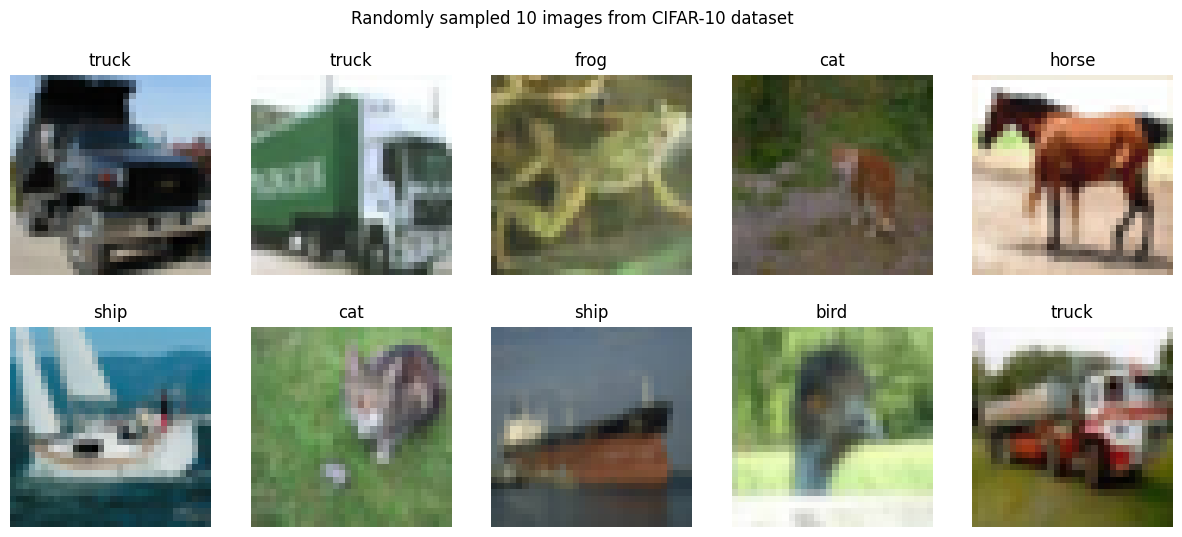

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Randomly sampled 10 images from CIFAR-10 dataset')
axs = axs.ravel()

for i in range(10):
  index = np.random.randint(0, dataset_size)
  img, label = cifar10[index]
  axs[i].axis('off')
  axs[i].imshow(img)
  axs[i].set_title(cifar10_classes[label])

plt.show()

# Load Model

## Load Architecture

In [ ]:
mobilenet_v2 = models.mobilenet_v2()

## Self Designed Modules

In [ ]:
class SimAM(nn.Module):
    def __init__(self, coeff_lambda=1e-4):
        super(SimAM, self).__init__()
        self.coeff_lambda = coeff_lambda

    def forward(self, X):
        """
        X: input tensor with shape (batch_size, num_channels, height, width)
        """
        assert X.dim() == 4, "shape of X must have 4 dimension"

        # spatial size
        n = X.shape[2] * X.shape[3] - 1

        # square of (t - u)
        d = (X - X.mean(dim=[2,3], keepdim=True)).pow(2)

        # d.sum() / n is channel variance
        v = d.sum(dim=[2,3], keepdim=True) / (n+1e-8)

        # E_inv groups all importance of X
        E_inv = d / (4 * (v + self.coeff_lambda)) + 0.5

        # return attended features
        return X * F.sigmoid(E_inv)

class Squeezer(nn.Module):
  def __init__(self):
    super(Squeezer, self).__init__()

  def forward(self, x):
    return torch.squeeze(x, dim=-1)

## Model Surgery

In [ ]:
mobilenet_v2_simam = nn.Sequential()

for name, module in mobilenet_v2.named_children():
  if name == 'features':
    feature_seq = nn.Sequential()
    mobilenet_v2_simam.add_module(name, feature_seq)

    for n0, m0 in module.named_children():
      if m0._get_name() == "Conv2dNormActivation":
        block = nn.Sequential()
        feature_seq.add_module(n0, block)

        for n1, m1 in m0.named_children():
          block.add_module(n1, m1)
          if (m1._get_name() == "Conv2d" or
              m1._get_name() == "BatchNorm2d"):
            block.add_module(f'{n1}_simam', SimAM())

      elif m0._get_name() == "InvertedResidual":
        block_big = nn.Sequential()                                             # BLOCKNAME: InvertedResidual
        feature_seq.add_module(n0, block_big)

        for n1, m1 in m0.named_children():
          block_med = nn.Sequential()                                           # BLOCKNAME: Sequential
          block_big.add_module(n1, block_med)

          for n2, m2 in m1.named_children():
            if m2._get_name() == "Conv2dNormActivation":
              block_small = nn.Sequential()                                     # BLOCKNAME: Conv2dNormActivation
              block_med.add_module(n2, block_small)

              for n3, m3 in m2.named_children():
                block_small.add_module(n3, m3)
                # if (m3._get_name() == "Conv2d" or
                #     m3._get_name() == "BatchNorm2d"):
                if m3._get_name() == "Conv2d":
                  block_small.add_module(f'{n3}_simam', SimAM())
            else:
              block_med.add_module(n2, m2)
              # if (m2._get_name() == "Conv2d" or
              #   m2._get_name() == "BatchNorm2d"):
              if m2._get_name() == "Conv2d":
                block_med.add_module(f'{n2}_simam', SimAM())

      else:
        raise ValueError("Sum ting wong")
  else:
    mobilenet_v2_simam.add_module('squeeze0', Squeezer())
    mobilenet_v2_simam.add_module('squeeze1', Squeezer())

    mobilenet_v2_simam.add_module(name, module)

device = "cuda" if torch.cuda.is_available() else "cpu"
mobilenet_v2_simam = mobilenet_v2_simam.to(device)

# Training

## Preprocessing

In [ ]:
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()
])

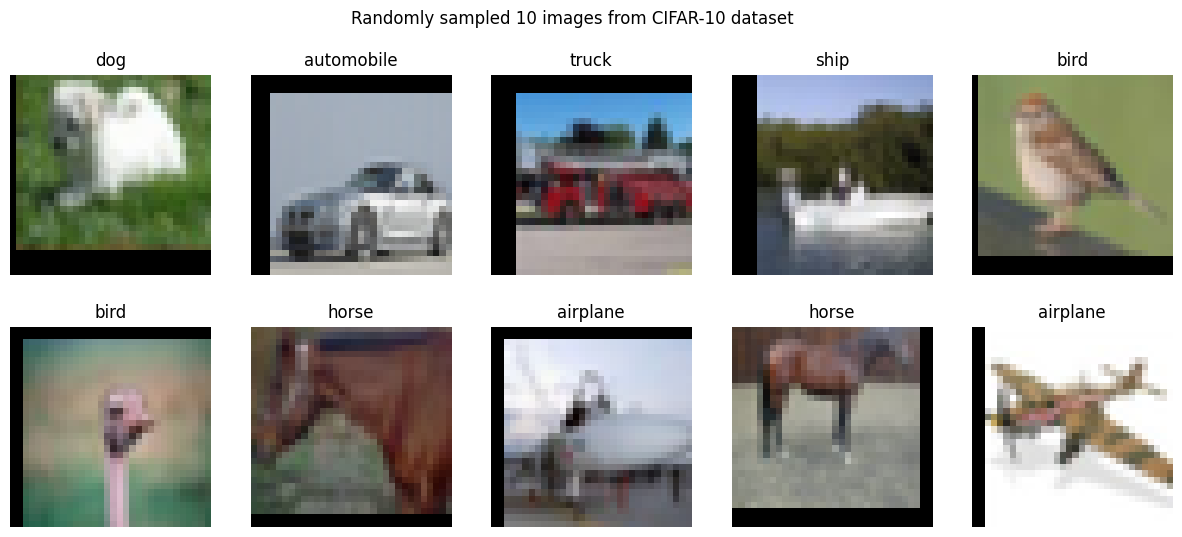

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Randomly sampled 10 images from CIFAR-10 dataset')
axs = axs.ravel()

for i in range(10):
  index = np.random.randint(0, dataset_size)
  axs[i].axis('off')
  img, label = cifar10[index]
  img = transform(img)
  axs[i].imshow(transforms.ToPILImage()(img))
  axs[i].set_title(cifar10_classes[label])

plt.show()

## Optimizer

In [ ]:
optimizer = optim.SGD(mobilenet_v2_simam.parameters(),
                      lr=0.1,
                      momentum=0.9,
                      weight_decay=5e-4)

## DataLoader

In [ ]:
cifar10_preprocessed = datasets.CIFAR10(data_path, train=True, download=False, transform=transform)
cifar10_val_preprocessed = datasets.CIFAR10(data_path, train=False, download=False, transform=transform)

cifar10_preprocessed_dataloader = [(img, label) for img, label in cifar10_preprocessed]
cifar10_val_preprocessed_dataloader = [(img, label) for img, label in cifar10_preprocessed]

In [ ]:
train_dataloader = DataLoader(cifar10_preprocessed_dataloader,
                              batch_size=128,
                              shuffle=True,
                              )
val_dataloader = DataLoader(cifar10_val_preprocessed_dataloader,
                            batch_size=128,
                            shuffle=True,
                            )


## Model Fitting

In [ ]:
criterion = nn.CrossEntropyLoss()

global_steps = 0
lr_reduced32k = False
lr_reduced48k = False

for epoch in range(100):
  for i, (images, labels) in enumerate(train_dataloader):
    # Move tensors to the configured device
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = mobilenet_v2_simam(images)
    loss = criterion(outputs, labels)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Update learning rate
    if global_steps >= 32000 and not lr_reduced32k:
      optimizer.lr = optimizer.lr/10
    elif global_steps >= 48000 and not lr_reduced48k:
      optimizer.lr = optimizer.lr/10

  # Print statistics
  if epoch % 10 == 0:
    print(f"Epoch {epoch}/{100}, Loss: {loss.item():.4f}")

print(f'Final Loss: {loss.item():.4f}')

Epoch 0/100, Loss: nan
Epoch 10/100, Loss: nan
Epoch 20/100, Loss: nan
Epoch 30/100, Loss: nan
Epoch 40/100, Loss: nan
Epoch 50/100, Loss: nan


In [ ]:
print(f'Final Loss: {loss.item():.4f}')

Final Loss: nan


In [ ]:
correct = 0
total = 0

mobilenet_v2_simam.eval()
with torch.no_grad():
  for i, (images, labels) in enumerate(val_dataloader):
    # Move tensors to the configured device
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = mobilenet_v2_simam(images)
    pred = torch.argmax(outputs, dim=1)

    total += labels.shape[0]
    correct += int((pred == labels).sum())

print("Accuracy: ", correct/total)

Accuracy:  0.1


In [ ]:
mobilenet_v2 = models.mobilenet_v2()
mobilenet_v2 = mobilenet_v2.to(device)

optimizer = optim.SGD(mobilenet_v2.parameters(),
                      lr=0.1,
                      momentum=0.9,
                      weight_decay=5e-4)

criterion = nn.CrossEntropyLoss()

global_steps = 0
lr_reduced32k = False
lr_reduced48k = False

for epoch in range(1, 101):
  for i, (images, labels) in enumerate(train_dataloader):
    # Move tensors to the configured device
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = mobilenet_v2(images)
    loss = criterion(outputs, labels)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Update learning rate
    if global_steps >= 32000 and not lr_reduced32k:
      optimizer.lr = optimizer.lr/10
    elif global_steps >= 48000 and not lr_reduced48k:
      optimizer.lr = optimizer.lr/10

  # Print statistics
  if epoch % 10 == 0:
    print(f"Epoch {epoch}/{100}, Loss: {loss.item():.4f}")

print(f'Final Loss: {loss.item():.4f}')

Epoch 0/100, Loss: 2.0527
Epoch 10/100, Loss: 1.0768
Epoch 20/100, Loss: 0.8210
Epoch 30/100, Loss: 0.8827
Epoch 40/100, Loss: 1.0423
Epoch 50/100, Loss: 0.9895
Epoch 60/100, Loss: 0.8454
Epoch 70/100, Loss: 0.8687
Epoch 80/100, Loss: 0.7292
Epoch 90/100, Loss: 0.9806
Final Loss: 1.0381


In [ ]:
correct = 0
total = 0

mobilenet_v2.eval()
with torch.no_grad():
  for i, (images, labels) in enumerate(val_dataloader):
    # Move tensors to the configured device
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = mobilenet_v2(images)
    pred = torch.argmax(outputs, dim=1)

    total += labels.shape[0]
    correct += int((pred == labels).sum())

print("Accuracy: ", correct/total)

Accuracy:  0.5701
